In [1]:
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append("../scripts")
from core import junction_potential
from graphics import simple_axes, adjust_raster_ticks, add_scalebar, hide_axes, offset_traces

In [2]:
def load_abf(pprox):
    """Reads the ABF file associated with an epoch """
    import nbank as nb
    from neo.io import AxonIO
    registry_url, resource_id = nb.parse_resource_id(pprox["source"])
    resource_path = nb.get(resource_id, registry_url, local_only=True)
    abf_path = (Path(resource_path) / pprox["abf_file"]).with_suffix(".abf")
    ifp = AxonIO(abf_path)
    return ifp.read_block(lazy=True)


In [132]:
base = Path("../build")
iv_stats = pd.read_csv(base / "iv_stats.csv", index_col=["cell", "epoch", "sweep"])
sweep_stats = pd.read_csv(base / "sweep_stats.csv", index_col=["cell", "epoch", "sweep"])
epoch_stats = pd.read_csv(base / "epoch_stats.csv", index_col=["cell", "epoch"])

In [ ]:
# tonic plastic
cell = "2d21b861"
epoch_idx = [3, 4, 5, 6, 7, 8]
sweep_idx = [10, 14, 17]

In [ ]:
# phasic stable
cell = "328b1402"
epoch_idx = [3, 4, 5, 6, 7]
sweep_idx = [10, 14, 17]

In [ ]:
# tonic stable - PR
cell = "8486a193"
epoch_idx = [2, 3, 4, 5, 6, 7]
sweep_idx = [12, 15, 18]

In [ ]:
# tonic stable - PR
cell = "0e40048d"
epoch_idx = [13, 14, 15, 17, 18, 19, 20]
sweep_idx = [10, 14, 18]

In [ ]:
# tonic stable - PR - long, bounces around a bit
cell = "54acfc7d"
epoch_idx = [2,5,6,7,8,9,10,11,12]
sweep_idx = [10, 14, 18]

In [ ]:
# tonic stable - PR
cell = "2fbb1b8f"
epoch_idx = [2,3,4,5,6,7,8]
sweep_idx = [11, 14, 17]

In [ ]:
# tonic Kv1.1-
ecll = "de634

In [ ]:
epochs = epoch_stats.loc[cell].loc[epoch_idx]
sweeps = sweep_stats.loc[cell].loc[epoch_idx]
steps = iv_stats.loc[cell].loc[epoch_idx]

In [ ]:
epochs

In [ ]:
bin_size = 10
floor = np.floor(steps.current.min() / bin_size) * bin_size
ceil  = np.ceil(steps.current.max() / bin_size) * bin_size
bins = np.arange(floor, ceil + bin_size, bin_size)
steps_binned = steps.groupby(["epoch", pd.cut(steps.current, bins, labels=False)]).mean()

In [ ]:
fig = plt.figure(figsize=(4.56, 3.7))
subfigs = fig.subfigures(1, 3)

axes = subfigs[1].subplots(2, sharex=True)
for enumber, epoch in steps_binned.groupby("epoch"):
    axes[0].plot(epoch.current, epoch.voltage, label="%d s" % int(epochs.loc[enumber].time))
axes[0].set_ylabel("V (mV)")
for enumber, epoch in sweeps.groupby("epoch"):
    axes[1].plot(epoch.current, epoch.firing_rate, label="%d s" % int(epochs.loc[enumber].time))
axes[1].set_ylabel("Firing rate (Hz)")
axes[1].set_xlabel("Current (pA)")
axes[1].legend()
simple_axes(*axes)
subfigs[1].align_ylabels(axes)

marker_style = {"marker": 'o', "markersize": 3, "linestyle": 'none', "fillstyle": "none"}
axes = subfigs[2].subplots(5, sharex=True, height_ratios=(2, 2, 2, 1, 1))
axes[0].errorbar(epochs.time, epochs.duration_mean, epochs.duration_sd / np.sqrt(epochs.n_spike_sweeps), **marker_style)
axes[0].set_ylim(0, 2.0)
axes[0].set_ylabel("Duration (s)")
axes[1].plot(epochs.time, epochs.slope, **marker_style)
axes[1].set_ylim(0, epochs.slope.max() * 1.1)
axes[1].set_ylabel("f-I slope (Hz/pA)")
axes[2].plot(epochs.time, epochs.rheobase, **marker_style)
axes[2].set_ylim(0, epochs.rheobase.max() * 1.1)
axes[2].set_ylabel("rheobase (pA)")
axes[3].errorbar(epochs.time, epochs.Vm, epochs.Vm_sd / np.sqrt(epochs.n_sweeps), **marker_style)
axes[3].set_ylim(epochs.Vm.mean() - 10, epochs.Vm.mean() + 10)
axes[3].set_ylabel("Vm (mV)")                  
axes[4].errorbar(epochs.time, epochs.Rm, epochs.Rm_sd / np.sqrt(epochs.n_sweeps), **marker_style)
Rmm = epochs.Rm.mean()
axes[4].set_ylim(Rmm * 0.7, Rmm * 1.3)
axes[4].set_ylabel("Rm (MΩ)")
axes[4].set_xlabel("Time (s)")
simple_axes(*axes)
#subfigs[2].subplots_adjust(hspace=0.08)
subfigs[2].align_ylabels(axes)

axes = subfigs[0].subplots(6, sharex=True, height_ratios=(2, 3, 0.5, 2, 3, 0.5))
aidx = 0
for eidx in [epoch_idx[0], epoch_idx[-1]]:
    s_ax = axes[aidx + 0]
    v_ax = axes[aidx + 1]
    i_ax = axes[aidx + 2]
    pprox = base / "{}_{:02}.pprox".format(cell, eidx)
    with open(pprox, "rt") as fp:
        epoch = json.load(fp)
    for idx, pproc in enumerate(epoch["pprox"]):
        s_ax.plot(pproc["events"], [idx] * len(pproc["events"]), '|')
    s_ax.set_ylim(5, idx)
    adjust_raster_ticks(s_ax, gap=2)
    
    block = load_abf(epoch)
    for sidx in sweep_idx:
        segment = block.segments[sidx]
        V = (
            (segment.analogsignals[0].load() - junction_potential)
            .rescale("mV")
        )
        I = (
            segment.analogsignals[1]
            .load()
            .rescale("pA")
        )
        color = s_ax.lines[sidx].get_color()
        t = V.times - V.t_start
        v_ax.plot(t, V.magnitude, color=color)
        i_ax.plot(t, I, color=color)
    offset_traces(v_ax)
    aidx += 3
hide_axes(axes[0], axes[3])
simple_axes(axes[1], axes[2], axes[4], axes[5])
axes[0].set_xlim(0.1, 2.3);

In [ ]:
fig.savefig(f"../figures/{cell}_plasticity.pdf")

## Reversal Experiments

In [4]:
reversal_epochs = pd.read_csv("../inputs/reversal_epochs.csv", index_col="epoch_cond").drop("mid").reset_index().set_index("cell")

In [5]:
# 4AP
cell = "a13d4c2b"
epoch_idx = reversal_epochs.loc[cell].epoch
sweep_idx = [12, 15, 18]

In [115]:
# dtx- can't use because tuning was on during acquisition
cell = "749bf2f7"
epoch_idx = [4, 14, 20]
sweep_idx = [12, 15, 18]

In [116]:
# dtx - washed out, but change was small
cell = "a13d4c2b"
epoch_idx = [2, 11, 16]
sweep_idx = [12, 15, 18]

In [120]:
# dtx - not much of a change
cell = "abaed061"
epoch_idx = [2, 9, 13]
sweep_idx = [12, 15, 18]

In [124]:
# dtx - OK on plasticity, but big IV change in the opposite direction as expected
cell = "c3359bea"
epoch_idx = [2, 8, 15]
sweep_idx = [12, 15, 18]

In [134]:
# dtx - OK on plasticity, but big IV change in the opposite direction as expected
cell = "6f5df6c5"
epoch_idx = [4, 10, 15]
sweep_idx = [12, 15, 18]

In [135]:
epochs = epoch_stats.loc[cell].loc[epoch_idx]
sweeps = sweep_stats.loc[cell].loc[epoch_idx]
steps = iv_stats.loc[cell].loc[epoch_idx]

In [136]:
bin_size = 10
floor = np.floor(steps.current.min() / bin_size) * bin_size
ceil  = np.ceil(steps.current.max() / bin_size) * bin_size
bins = np.arange(floor, ceil + bin_size, bin_size)
steps_binned = steps.groupby(["epoch", pd.cut(steps.current, bins, labels=False)]).mean()

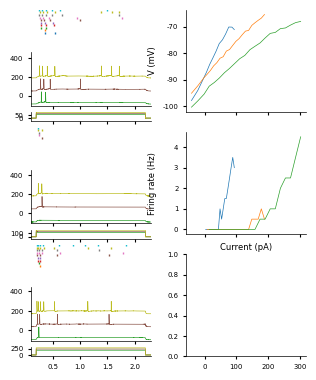

In [137]:
fig = plt.figure(figsize=(3.1, 4.5))
subfigs = fig.subfigures(1, 2)

axes = subfigs[1].subplots(3, sharex=True)
for enumber, epoch in steps_binned.groupby("epoch"):
    axes[0].plot(epoch.current, epoch.voltage, label="%d s" % int(epochs.loc[enumber].time))
axes[0].set_ylabel("V (mV)")
for enumber, epoch in sweeps.groupby("epoch"):
    axes[1].plot(epoch.current, epoch.firing_rate, label="%d s" % int(epochs.loc[enumber].time))
axes[1].set_ylabel("Firing rate (Hz)")
axes[1].set_xlabel("Current (pA)")
#axes[1].legend()
simple_axes(*axes)
subfigs[1].align_ylabels(axes)

axes = subfigs[0].subplots(9, sharex=True, height_ratios=(2, 3, 0.5, 2, 3, 0.5, 2, 3, 0.5))
aidx = 0
for eidx in [epoch_idx[0], epoch_idx[1], epoch_idx[2]]:
    s_ax = axes[aidx + 0]
    v_ax = axes[aidx + 1]
    i_ax = axes[aidx + 2]
    pprox = base / "{}_{:02}.pprox".format(cell, eidx)
    with open(pprox, "rt") as fp:
        epoch = json.load(fp)
    for idx, pproc in enumerate(epoch["pprox"]):
        s_ax.plot(pproc["events"], [idx] * len(pproc["events"]), '|')
    s_ax.set_ylim(5, idx)
    adjust_raster_ticks(s_ax, gap=1)
    
    block = load_abf(epoch)
    for sidx in sweep_idx:
        segment = block.segments[sidx]
        V = (
            (segment.analogsignals[0].load() - junction_potential)
            .rescale("mV")
        )
        I = (
            segment.analogsignals[1]
            .load()
            .rescale("pA")
        )
        color = s_ax.lines[sidx].get_color()
        t = V.times - V.t_start
        v_ax.plot(t, V.magnitude, color=color)
        i_ax.plot(t, I, color=color)
    offset_traces(v_ax)
    aidx += 3
hide_axes(axes[0], axes[3], axes[6])
simple_axes(axes[1], axes[2], axes[4], axes[5], axes[7], axes[8])
axes[0].set_xlim(0.1, 2.3);

In [ ]:
fig.savefig(f"../figures/{cell}_reversal.pdf")